## San Francisco Restaurant Health Scores and Violations

This dataset was pulled from Kaggle. The link to can be found [here](https://www.kaggle.com/san-francisco/sf-restaurant-scores-lives-standard).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as stats
import seaborn as sns

In [2]:
temp_df = pd.read_csv('restaurant-scores-lives-standard.csv')

In [3]:
temp_df = temp_df.drop(columns=['business_id', 'business_phone_number', 'business_city', 'business_state', 'business_location', 'business_address', 'Zip Codes'])
#let's drop any records with null target values
temp_df = temp_df.dropna(subset=['inspection_score']).reset_index()

In [4]:
temp_df.shape

(39514, 17)

In [5]:
temp_df.loc[temp_df['business_name'] == 'Parada 22']

,index,business_name,business_postal_code,business_latitude,business_longitude,inspection_id,inspection_date,inspection_score,inspection_type,violation_id,violation_description,risk_category,Neighborhoods,Police Districts,Supervisor Districts,Fire Prevention Districts,Analysis Neighborhoods
17,40,Parada 22,94117,37.769303,-122.451961,62051_20180514,2018-05-14T00:00:00.000,86.0,Routine - Unscheduled,62051_20180514_103154,Unclean or degraded floors walls or ceilings,Low Risk,9.0,5.0,11.0,15.0,3.0
664,1140,Parada 22,94117,37.769303,-122.451961,62051_20180514,2018-05-14T00:00:00.000,86.0,Routine - Unscheduled,62051_20180514_103133,Foods not protected from contamination,Moderate Risk,9.0,5.0,11.0,15.0,3.0
713,1224,Parada 22,94117,37.769303,-122.451961,62051_20180514,2018-05-14T00:00:00.000,86.0,Routine - Unscheduled,62051_20180514_103132,Improper thawing methods,Moderate Risk,9.0,5.0,11.0,15.0,3.0
1866,3010,Parada 22,94117,37.769303,-122.451961,62051_20180514,2018-05-14T00:00:00.000,86.0,Routine - Unscheduled,62051_20180514_103116,Inadequate food safety knowledge or lack of ce...,Moderate Risk,9.0,5.0,11.0,15.0,3.0
29390,40887,Parada 22,94117,37.769303,-122.451961,62051_20190509,2019-05-09T00:00:00.000,88.0,Routine - Unscheduled,62051_20190509_103154,Unclean or degraded floors walls or ceilings,Low Risk,9.0,5.0,11.0,15.0,3.0
30965,42869,Parada 22,94117,37.769303,-122.451961,62051_20190509,2019-05-09T00:00:00.000,88.0,Routine - Unscheduled,62051_20190509_103124,Inadequately cleaned or sanitized food contact...,Moderate Risk,9.0,5.0,11.0,15.0,3.0
32390,44707,Parada 22,94117,37.769303,-122.451961,62051_20190509,2019-05-09T00:00:00.000,88.0,Routine - Unscheduled,62051_20190509_103144,Unapproved or unmaintained equipment or utensils,Low Risk,9.0,5.0,11.0,15.0,3.0


Well, there are multiple entries for the same inspection. We really only want one, so let's make that happen.

In [6]:
#drop rows where there is no violation description, but they still had points subtracted
drop_index = temp_df.loc[(temp_df.violation_description.isnull()) & (temp_df.inspection_score < 100)].index
temp_df.drop(drop_index, inplace=True)

In [7]:
temp_df.loc[temp_df.violation_description.isnull(), 'inspection_score'].mean()

100.0

In [8]:
#no violation description means there was no violation - that's why they got a 100!
temp_df['violation_description'].fillna('No violation', inplace=True)

In [9]:
#loop through all the inspection id's and create a df of only one instance
ins_ids = temp_df['inspection_id'].unique()

names = []
zip_codes = []
lat = []
long = []
ids = []
date = []
score = []
ins_type = []
viol_id = []
neighborhoods = []
pol_dist = []
sup_dist = []
fire_dist = []
analy_nei = []
num_violations = []

for id in ins_ids:
    #new df for our one restaurant
    restaurant = temp_df.loc[temp_df.inspection_id == id]
    #sometimes there are no data for the inspection id?
    if (len(restaurant) > 0):
        #grab the index of the first one
        index = restaurant.index[0]
        #start appending some values
        names.append(restaurant['business_name'][index])
        zip_codes.append(restaurant['business_postal_code'][index])
        lat.append(restaurant['business_latitude'][index])
        long.append(restaurant['business_longitude'][index])
        ids.append(restaurant['inspection_id'][index])
        date.append(restaurant['inspection_date'][index])
        score.append(restaurant['inspection_score'][index])
        ins_type.append(restaurant['inspection_type'][index])
        viol_id.append(restaurant['violation_id'][index])
        neighborhoods.append(restaurant['Neighborhoods'][index])
        pol_dist.append(restaurant['Police Districts'][index])
        sup_dist.append(restaurant['Supervisor Districts'][index])
        fire_dist.append(restaurant['Fire Prevention Districts'][index])
        analy_nei.append(restaurant['Analysis Neighborhoods'][index])
        #if the score is 100, then there were no violations. All the others are counted and appended
        if (restaurant['inspection_score'][index] == 100):
            num_violations.append(0)
        else:
            num_violations.append(len(restaurant))

In [10]:
df = pd.DataFrame()

df['business_name'] = names
df['business_postal_code'] =  zip_codes
df['business_latitude'] =  lat
df['business_longitude'] = long
df['inspection_id'] = ids
df['inspection_date'] = date
df['inspection_score'] =  score
df['inspection_type'] =  ins_type
df['violation_id'] =  viol_id
df['Neighborhoods'] =  neighborhoods
df['Police Districts'] =  pol_dist
df['Supervisor Districts'] =  sup_dist
df['Fire Prevention Districts'] =  fire_dist
df['Analysis Neighborhoods'] =  analy_nei
df['num_violations'] =  num_violations

In [11]:
print(df.inspection_id.nunique())
print(len(df))

12020
12020


In [12]:
temp_df.loc[temp_df.risk_category.isnull(), 'inspection_score'].mean()

100.0

In [13]:
#null risk category means there was no violation and no risk
temp_df.risk_category.fillna('No Violation', inplace=True)

Let's create counts of our different risk categories.

In [14]:
low_risk = []
medium_risk = []
high_risk = []
no_risk_violation = []

ins_ids = temp_df['inspection_id'].unique()

for id in ins_ids:
    #each restaurant and the unique category counts
    restaurant = temp_df.loc[temp_df.inspection_id == id]
    counts = restaurant['risk_category'].value_counts()
    
    try:
        low_risk.append(counts['Low Risk'])
    except:
        low_risk.append(0)
        
    try:
        medium_risk.append(counts['Moderate Risk'])
    except:
        medium_risk.append(0)
        
    try:
        high_risk.append(counts['High Risk'])
    except:
        high_risk.append(0)
        
    try:
        no_risk_violation.append(counts['No Violation'])
    except:
        no_risk_violation.append(0)

In [15]:
df['low_risk_count'] = low_risk
df['medium_risk_count'] = medium_risk
df['high_risk_count'] = high_risk
df['no_risk_count'] = no_risk_violation

In [16]:
import calendar
df['inspection_date'] = pd.to_datetime(df['inspection_date'])


df['Year'] = df['inspection_date'].dt.year
df['Month'] = df['inspection_date'].dt.month
df['Date'] = df['inspection_date'].dt.day
df['Day'] = df['inspection_date'].apply(lambda x: calendar.day_name[x.weekday()])

In [17]:
df.shape

(12020, 23)

In [18]:
filling_nans = ['Neighborhoods', 'Police Districts', 'Supervisor Districts', 'Fire Prevention Districts', 'Analysis Neighborhoods']

for column in filling_nans:
    df[column].fillna(df[column].median(), inplace=True)

In [19]:
df = df.drop(columns=['violation_id', 'business_latitude', 'business_longitude'])

In [20]:
for i in range(len(df.business_name)):
    if (df['business_name'][i] == 'ghirardelli chocolate'):
        df['business_postal_code'][i] = 94103

In [21]:
for i in range(len(df.business_name)):
    if (df['business_name'][i] == 'sunrise deli'):
        df['business_postal_code'][i] = 94122

In [22]:
null = df.isnull().sum() / len(df) * 100
null[null > 0]

business_postal_code    2.479201
dtype: float64

In [23]:
df.shape

(12020, 20)

In [24]:
df.dropna(inplace=True)

In [25]:
df.shape

(11722, 20)

In [26]:
print(min(df['inspection_date']))
print(max(df['inspection_date']))

2016-08-02 00:00:00
2019-08-01 00:00:00


In [27]:
numeric_columns = df.select_dtypes(include=['float64'])
cat_cols = df.loc[:, ~df.columns.isin(numeric_columns)]
cat_cols = cat_cols.drop(columns=['inspection_date', 'business_name', 'inspection_id'])

inspection_score
Correlation: 1.0 -- p_value: 0.0


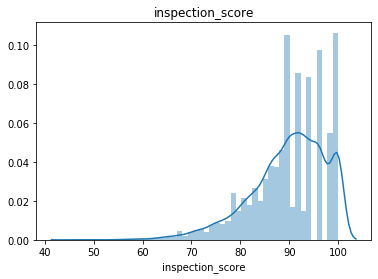

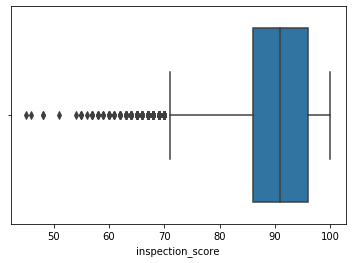

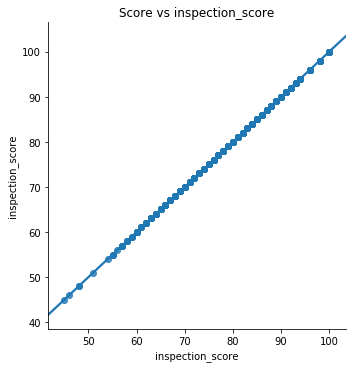


Neighborhoods
Correlation: 0.024799609060941346 -- p_value: 0.007250045680536725


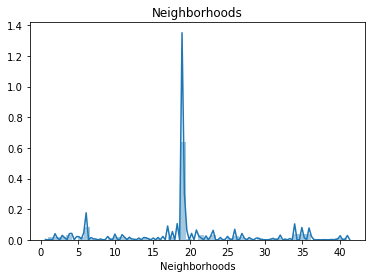

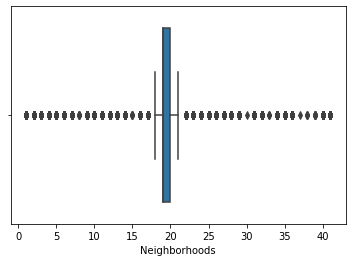

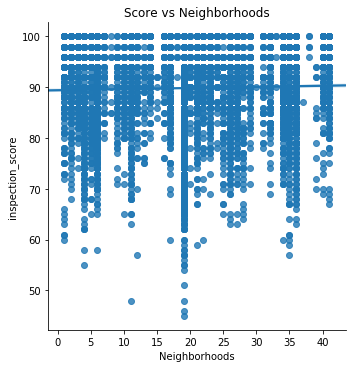


Police Districts
Correlation: -0.007822453978716684 -- p_value: 0.39708122326178974


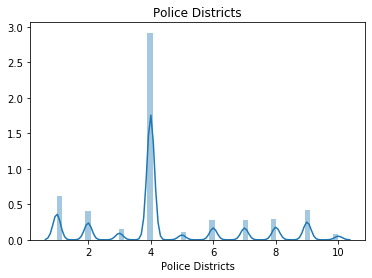

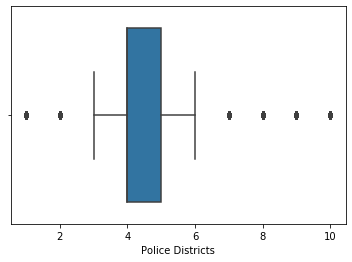

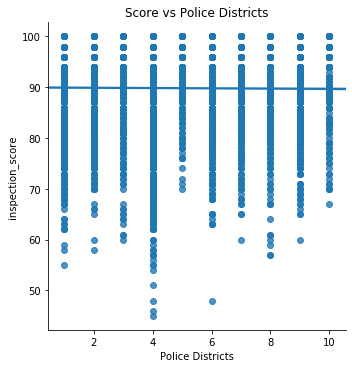


Supervisor Districts
Correlation: 0.006403145150774853 -- p_value: 0.4881902714413519


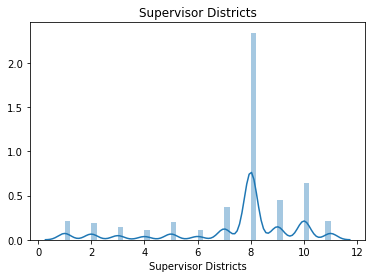

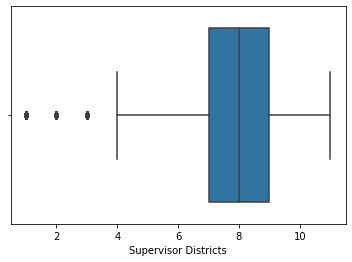

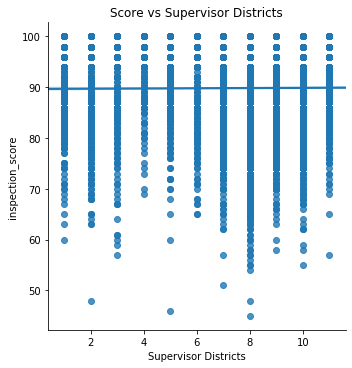


Fire Prevention Districts
Correlation: -0.02905799305378959 -- p_value: 0.0016530223923176869


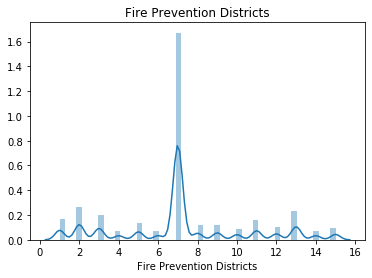

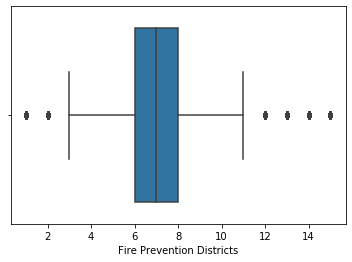

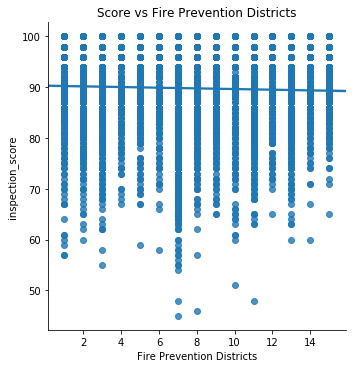


Analysis Neighborhoods
Correlation: 0.021124018623361 -- p_value: 0.022191711825141465


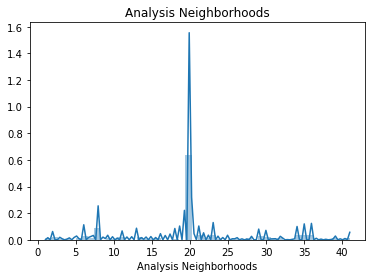

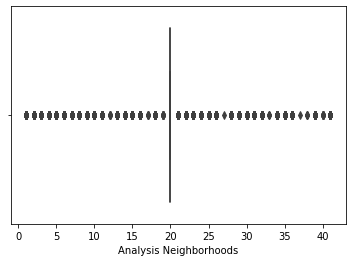

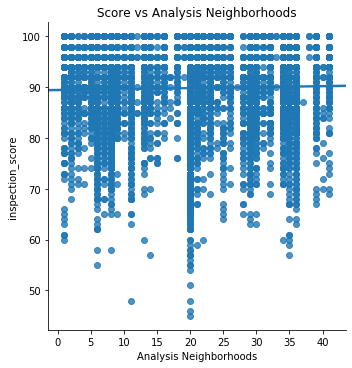

In [28]:
for column in numeric_columns:
    corr, p_value = stats.pearsonr(df[column], df.inspection_score)
    print('{}'.format(column))
    print('Correlation: {} -- p_value: {}'.format(corr, p_value))
    sns.distplot(df[column])
    plt.title('{}'.format(column))
    plt.show()
    
    sns.boxplot(df[column])
    plt.show()
    
    sns.lmplot(x=column, y='inspection_score', data=df)
    plt.title('Score vs {}'.format(column))
    plt.show()
    print('')

In [30]:
columns = numeric_columns.columns
r_squared = []
p_value = []
for column in numeric_columns:
    corr, p = stats.pearsonr(df[column], df.inspection_score)
    r_squared.append(abs(corr))
    p_value.append(p)
    
r_values = pd.DataFrame()
r_values['feature'] = columns
r_values['r_squared'] = r_squared
r_values['p_value'] = p_value

r_values = r_values.sort_values(by='r_squared', ascending=False).reset_index()
r_values

,index,feature,r_squared,p_value
0,0,inspection_score,1.000000,0.000000
1,4,Fire Prevention Districts,0.029058,0.001653
2,1,Neighborhoods,0.024800,0.007250
3,5,Analysis Neighborhoods,0.021124,0.022192
4,2,Police Districts,0.007822,0.397081
5,3,Supervisor Districts,0.006403,0.488190


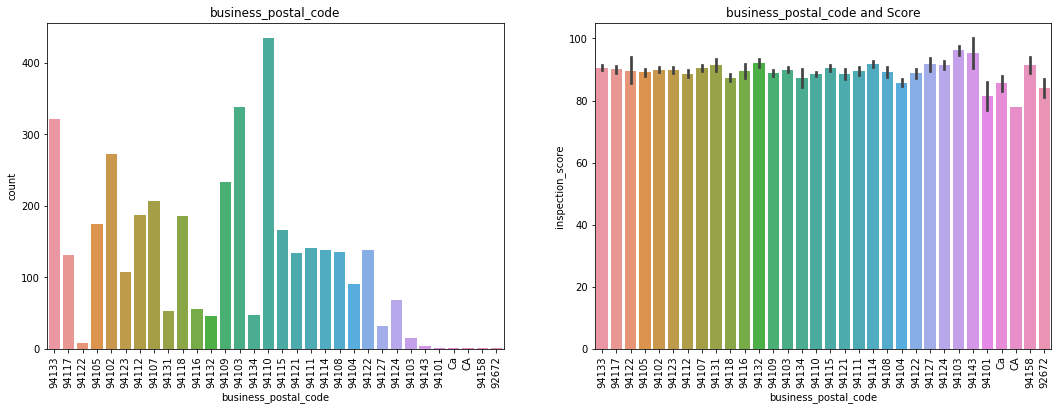

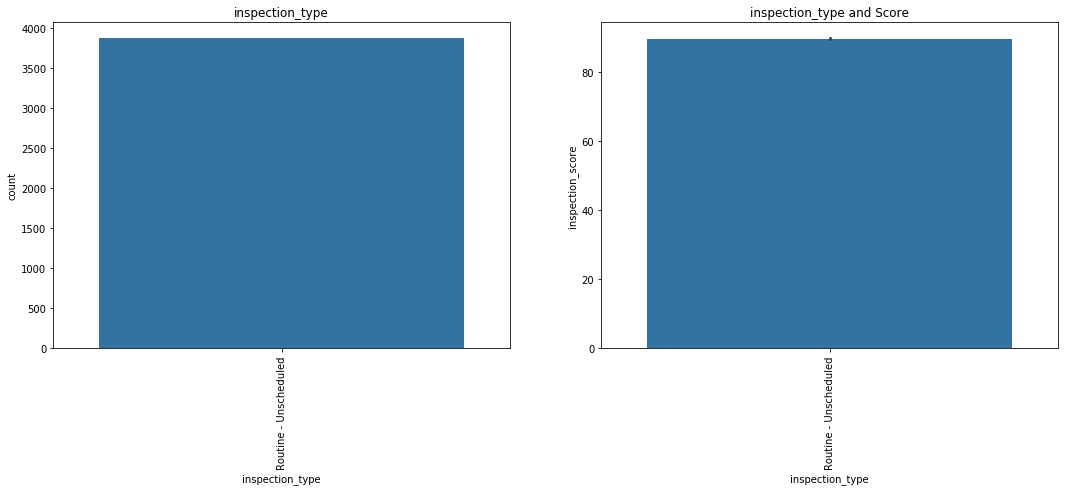

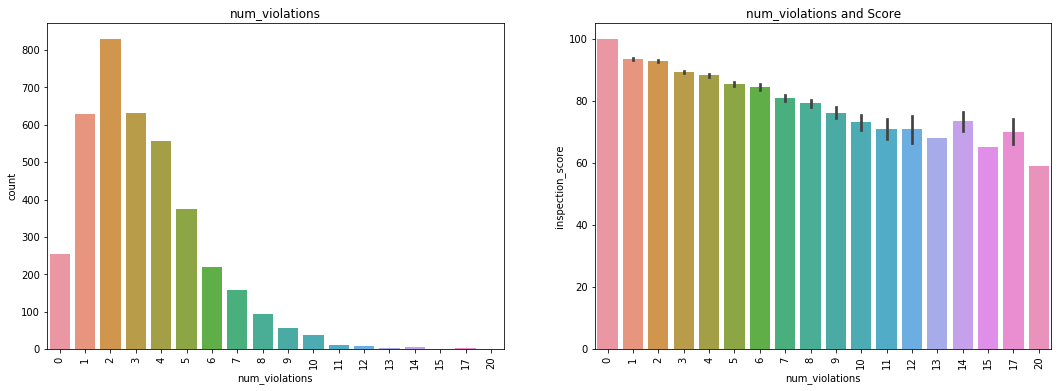

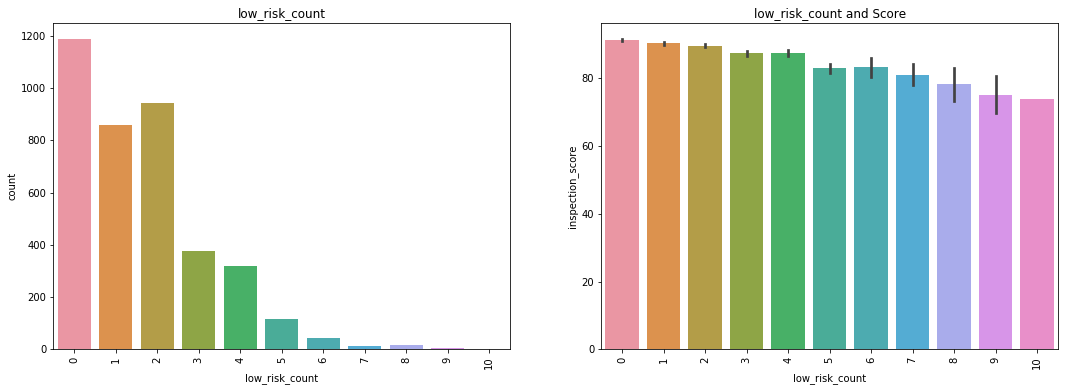

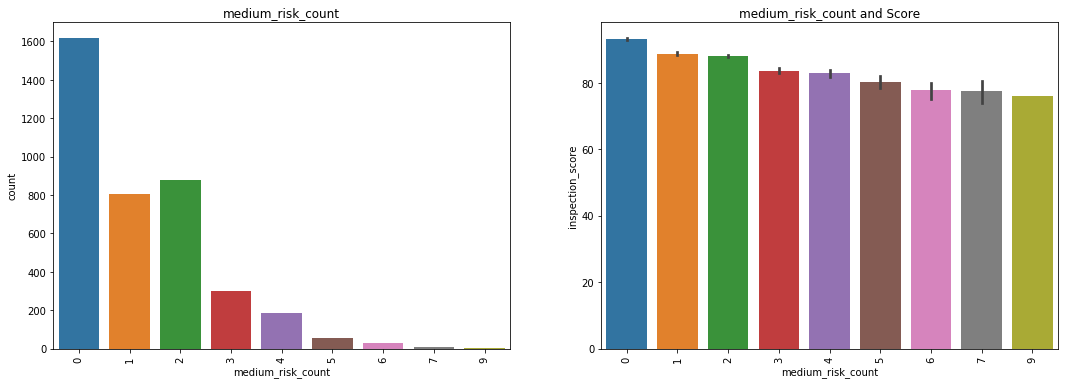

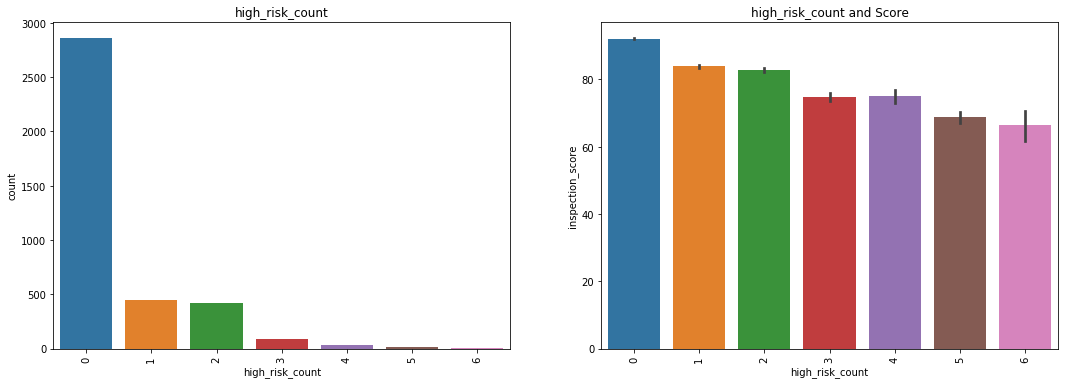

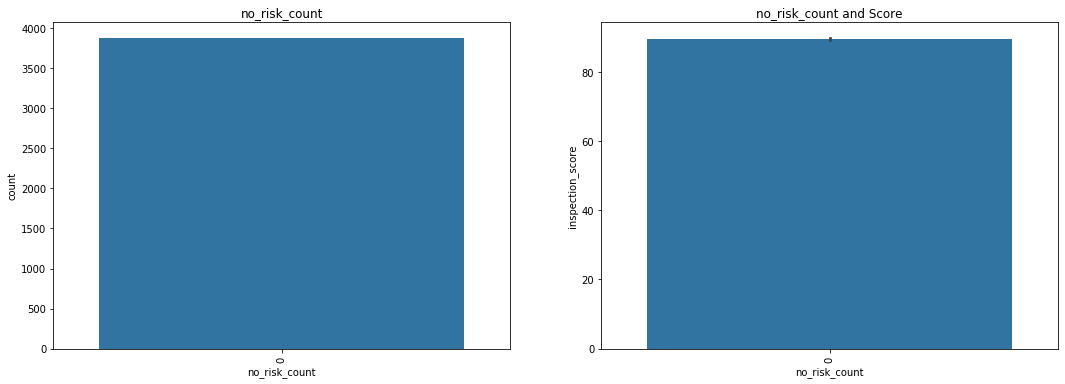

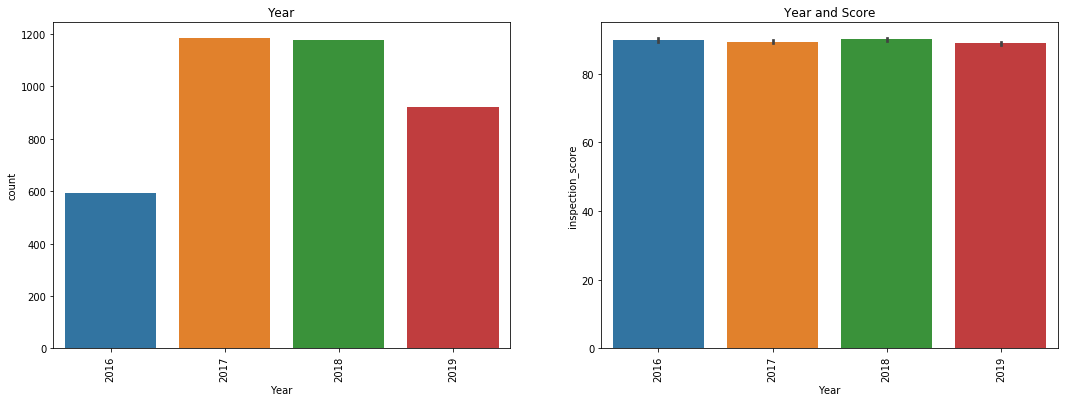

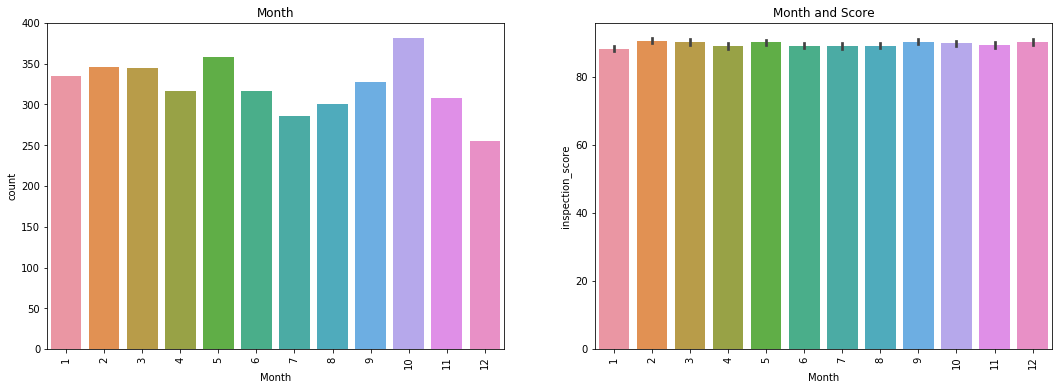

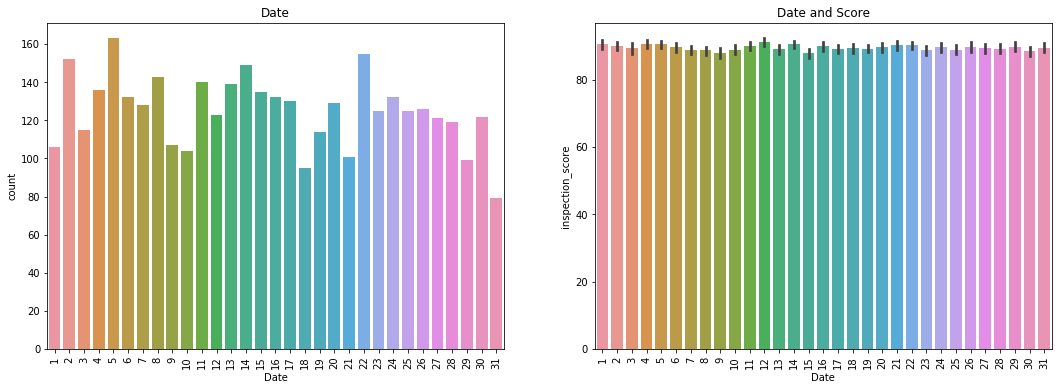

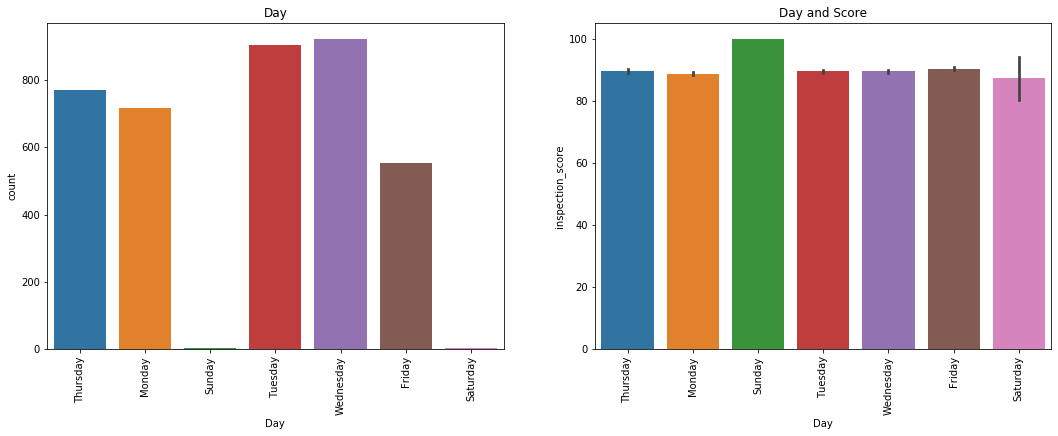

In [168]:
for column in cat_cols:
    plt.figure(figsize=(18, 6))
    
    plt.subplot(1, 2, 1)
    sns.countplot(df[column])
    plt.xticks(rotation='vertical')
    plt.title('{}'.format(column))
    
    plt.subplot(1, 2, 2)
    sns.barplot(x=column, y='inspection_score', data=df)
    plt.title('{} and Score'.format(column))
    plt.xticks(rotation='vertical')
    plt.show()

In [28]:
cat_features = ['num_violations', 'low_risk_count', 'medium_risk_count', 'high_risk_count', 'no_risk_count']

In [29]:
postal_code = pd.get_dummies(df['business_postal_code'], drop_first=True)
name = pd.get_dummies(df['business_name'], drop_first=True)
day = pd.get_dummies(df['Day'], drop_first=True)
year = pd.get_dummies(df['Year'], drop_first=True)
month = pd.get_dummies(df['Month'], drop_first=True)
date = pd.get_dummies(df['Date'], drop_first=True)

dummies_df = pd.concat([postal_code, name, day, year, month, date], axis=1)

In [30]:
X = pd.concat([numeric_columns, dummies_df], axis=1) 
X = X.drop(columns=['inspection_score'])
y = df['inspection_score']

### Random Forest Model

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [46]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(n_estimators=100, max_features='sqrt')
rfr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='sqrt', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [47]:
print('The r^2 of our test data is {}'.format(round(rfr.score(X_test, y_test), 4)))
print('The r^2 of our training data is {}'.format(round(rfr.score(X_train, y_train), 4)))

The r^2 of our test data is 0.1452
The r^2 of our training data is 0.8824


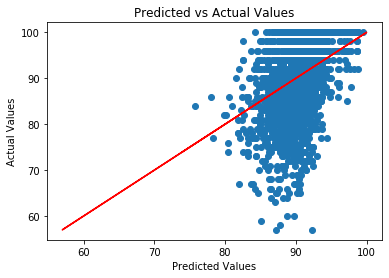

Root mean squared error of the prediction is: 7.2052223010138325
Mean absolute percentage error of the prediction is: 6.511750074295016%


In [48]:
from statsmodels.tools.eval_measures import rmse

y_preds = rfr.predict(X_test)

plt.scatter(y_preds, y_test)
plt.plot(y_test, y_test, color='red')
plt.title('Predicted vs Actual Values')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()

print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}%".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

In [49]:
columns = X_test.columns
feature_importances = rfr.feature_importances_

rfr_features = pd.DataFrame()
rfr_features['features'] = columns
rfr_features['importance'] = feature_importances

rfr_features = rfr_features.sort_values(by='importance', ascending=False).reset_index()
rfr_features.head(20)

,index,features,importance
0,3,Fire Prevention Districts,0.019716
1,4,Analysis Neighborhoods,0.018476
2,0,Neighborhoods,0.018348
3,2,Supervisor Districts,0.017525
4,1,Police Districts,0.014569
5,4935,Tuesday,0.011996
6,4937,2017,0.011582
7,4936,Wednesday,0.010771
8,4938,2018,0.010676
9,4934,Thursday,0.010643


### Scaled Data

In [33]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=10)

## KNN

__Uniform Distance__

In [51]:
from sklearn.neighbors import KNeighborsRegressor

parameters = {'n_neighbors' : np.arange(1, 31, 1)}
knr = KNeighborsRegressor()
reg = GridSearchCV(knr, parameters, cv=5)

reg.fit(X_train, y_train)
print('The r^2 of our test data is {}'.format(round(reg.score(X_test, y_test), 4)))
print('The r^2 of our training data is {}'.format(round(reg.score(X_train, y_train), 4)))

The r^2 of our test data is -0.0244
The r^2 of our training data is 0.5545


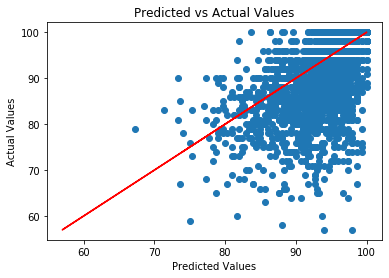

Root mean squared error of the prediction is: 7.887574759327789
Mean absolute percentage error of the prediction is: 6.905842582430583%


In [54]:
y_preds = reg.predict(X_test)

plt.scatter(y_preds, y_test)
plt.plot(y_test, y_test, color='red')
plt.title('Predicted vs Actual Values')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()

print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}%".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

In [53]:
reg.cv_results_

{'mean_fit_time': array([4.18528581, 4.13899212, 3.80441389, 4.20700488, 4.01698656,
        4.11167345, 4.13212237, 4.05752716, 4.12647805, 4.13533864,
        4.15762901, 4.45701151, 4.1519495 , 4.18878703, 4.38241539,
        4.447821  , 4.43076549, 4.42730727, 4.17726817, 4.81460004,
        4.41309538, 4.34679742, 4.33302526, 4.27820587, 4.5373909 ,
        4.44462304, 4.28043718, 4.36978025, 4.40281281, 4.38817677]),
 'std_fit_time': array([0.36471871, 0.25706816, 0.11752344, 0.20505687, 0.09315761,
        0.16591724, 0.15949077, 0.13392227, 0.08808994, 0.13980954,
        0.19029748, 0.29963502, 0.17369747, 0.16392464, 0.15317793,
        0.49280984, 0.12627772, 0.23994007, 0.17083389, 0.7198093 ,
        0.28628542, 0.20014915, 0.29651936, 0.19315596, 0.2458361 ,
        0.26991991, 0.298923  , 0.24694055, 0.19957194, 0.40748485]),
 'mean_score_time': array([ 41.11717587, 106.40080829, 124.90472708, 131.98543339,
        130.97245359, 135.28611817, 134.74204211, 135.56523194,


__Weighted Distance__

In [82]:
knr = KNeighborsRegressor(n_neighbors=19, weights='distance')

knr.fit(X_train, y_train)

0.7487118798877912
0.6790170469185737


In [83]:
print('The r^2 of our test data is {}'.format(round(knr.score(X_test, y_test), 4)))
print('The r^2 of our training data is {}'.format(round(knr.score(X_train, y_train), 4)))

The r^2 of our test data is 0.679
The r^2 of our training data is 0.7487


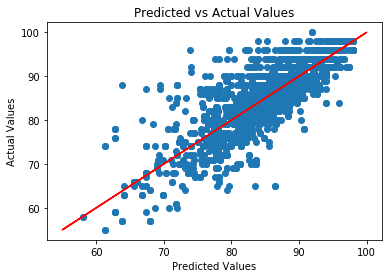

Root mean squared error of the prediction is: 4.6009696244982
Mean absolute percentage error of the prediction is: 3.9001121895190347%


In [84]:
y_preds = knr.predict(X_test)

plt.scatter(y_preds, y_test)
plt.plot(y_test, y_test, color='red')
plt.title('Predicted vs Actual Values')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()

print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}%".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

## Ridge Regression

In [34]:
from sklearn.linear_model import Ridge

ranges = []

for i in range(1, 10):
    ranges.append(10**i)

parameters = {'alpha' : ranges}

ridgeregr = Ridge()
reg = GridSearchCV(ridgeregr, parameters, cv=5)
reg.fit(X_train, y_train)


print('The r^2 of our test data is {}'.format(round(reg.score(X_test, y_test), 4)))
print('The r^2 of our training data is {}'.format(round(reg.score(X_train, y_train), 4)))

The r^2 of our test data is 0.2891
The r^2 of our training data is 0.7806


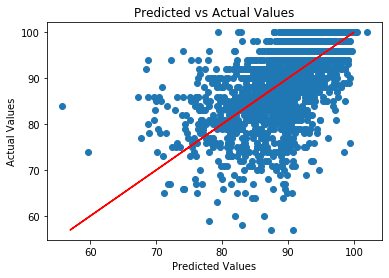

Root mean squared error of the prediction is: 6.570604021783365
Mean absolute percentage error of the prediction is: 5.729800074739865%


In [36]:
from statsmodels.tools.eval_measures import rmse

y_preds = reg.predict(X_test)


plt.scatter(y_preds, y_test)
plt.plot(y_test, y_test, color='red')
plt.title('Predicted vs Actual Values')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()


print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}%".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

In [37]:
reg.best_estimator_

Ridge(alpha=1000, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

## Bagging Regressor

In [49]:
#go back to our non-scaled data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [50]:
from sklearn.ensemble import BaggingRegressor

parameters = {'n_estimators' : np.arange(1, 110, 10), 'max_samples' : np.arange(0.2, 1.2, 0.2), 'max_features' : np.arange(0.2, 1.2, 0.2)}

bgr = BaggingRegressor()
reg = GridSearchCV(bgr, parameters, cv=5)
reg.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=BaggingRegressor(base_estimator=None, bootstrap=True,
                                        bootstrap_features=False,
                                        max_features=1.0, max_samples=1.0,
                                        n_estimators=10, n_jobs=None,
                                        oob_score=False, random_state=None,
                                        verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'max_features': array([0.2, 0.4, 0.6, 0.8, 1. ]),
                         'max_samples': array([0.2, 0.4, 0.6, 0.8, 1. ]),
                         'n_estimators': array([  1,  11,  21,  31,  41,  51,  61,  71,  81,  91, 101])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [51]:
print('The r^2 of our test data is {}'.format(round(reg.score(X_test, y_test), 4)))
print('The r^2 of our training data is {}'.format(round(reg.score(X_train, y_train), 4)))

The r^2 of our test data is 0.1657
The r^2 of our training data is 0.8424


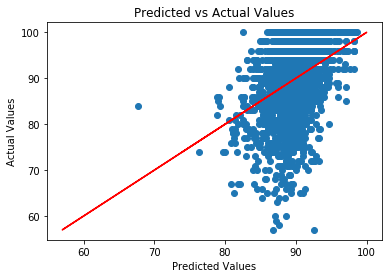

Root mean squared error of the prediction is: 7.1184525630794
Mean absolute percentage error of the prediction is: 6.45584419559202%


In [52]:
y_preds = reg.predict(X_test)

plt.scatter(y_preds, y_test)
plt.plot(y_test, y_test, color='red')
plt.title('Predicted vs Actual Values')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()

print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}%".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

In [53]:
reg.best_estimator_

BaggingRegressor(base_estimator=None, bootstrap=True, bootstrap_features=False,
                 max_features=0.6000000000000001, max_samples=1.0,
                 n_estimators=91, n_jobs=None, oob_score=False,
                 random_state=None, verbose=0, warm_start=False)

## Let's try our top 2 models without names

In [ ]:
cat_features = ['num_violations', 'low_risk_count', 'medium_risk_count', 'high_risk_count', 'no_risk_count']

In [57]:
postal_code = pd.get_dummies(df['business_postal_code'], drop_first=True)
name = pd.get_dummies(df['business_name'], drop_first=True)
day = pd.get_dummies(df['Day'], drop_first=True)
year = pd.get_dummies(df['Year'], drop_first=True)
month = pd.get_dummies(df['Month'], drop_first=True)
date = pd.get_dummies(df['Date'], drop_first=True)

dummies_df = pd.concat([postal_code, day, year, month, date], axis=1)

In [58]:
X = pd.concat([numeric_columns, dummies_df], axis=1) 
X = X.drop(columns=['inspection_score'])
y = df['inspection_score']

### Random Forest Regression

In [59]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [61]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(n_estimators=100, max_features='sqrt')
rfr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='sqrt', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [63]:
print('The r^2 of our test data is {}'.format(round(rfr.score(X_test, y_test), 4)))
print('The r^2 of our training data is {}'.format(round(rfr.score(X_train, y_train), 4)))

The r^2 of our test data is -0.0178
The r^2 of our training data is 0.7604


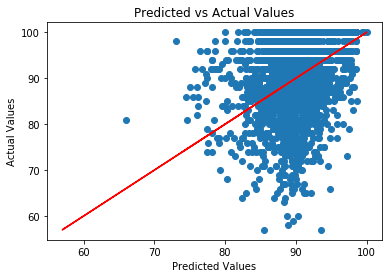

Root mean squared error of the prediction is: 7.8621111888184005
Mean absolute percentage error of the prediction is: 7.1137824916851375%


In [64]:
from statsmodels.tools.eval_measures import rmse

y_preds = rfr.predict(X_test)

plt.scatter(y_preds, y_test)
plt.plot(y_test, y_test, color='red')
plt.title('Predicted vs Actual Values')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()

print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}%".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

### Bagging Regressor

In [65]:
bgr = BaggingRegressor(max_features=0.6, max_samples=1.0, n_estimators=90)
bgr.fit(X_train, y_train)

BaggingRegressor(base_estimator=None, bootstrap=True, bootstrap_features=False,
                 max_features=0.6, max_samples=1.0, n_estimators=90,
                 n_jobs=None, oob_score=False, random_state=None, verbose=0,
                 warm_start=False)

In [66]:
print('The r^2 of our test data is {}'.format(round(bgr.score(X_test, y_test), 4)))
print('The r^2 of our training data is {}'.format(round(bgr.score(X_train, y_train), 4)))

The r^2 of our test data is 0.029
The r^2 of our training data is 0.6445


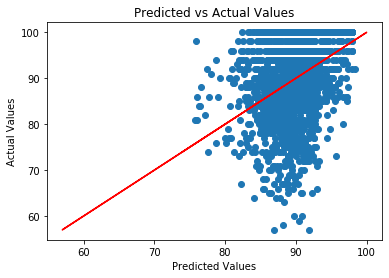

Root mean squared error of the prediction is: 7.679297570215854
Mean absolute percentage error of the prediction is: 6.988606736733121%


In [68]:
y_preds = bgr.predict(X_test)

plt.scatter(y_preds, y_test)
plt.plot(y_test, y_test, color='red')
plt.title('Predicted vs Actual Values')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()

print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}%".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

## Now let's try, but add the violations

In [69]:
cat_features = ['num_violations', 'low_risk_count', 'medium_risk_count', 'high_risk_count', 'no_risk_count']

In [70]:
postal_code = pd.get_dummies(df['business_postal_code'], drop_first=True)
name = pd.get_dummies(df['business_name'], drop_first=True)
day = pd.get_dummies(df['Day'], drop_first=True)
year = pd.get_dummies(df['Year'], drop_first=True)
month = pd.get_dummies(df['Month'], drop_first=True)
date = pd.get_dummies(df['Date'], drop_first=True)

dummies_df = pd.concat([postal_code, name, day, year, month, date, df[cat_features]], axis=1)

In [71]:
X = pd.concat([numeric_columns, dummies_df], axis=1) 
X = X.drop(columns=['inspection_score'])
y = df['inspection_score']

### Random Forest Regression

In [72]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(n_estimators=100, max_features='sqrt')
rfr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='sqrt', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [73]:
print('The r^2 of our test data is {}'.format(round(rfr.score(X_test, y_test), 4)))
print('The r^2 of our training data is {}'.format(round(rfr.score(X_train, y_train), 4)))

The r^2 of our test data is -0.0167
The r^2 of our training data is 0.7587


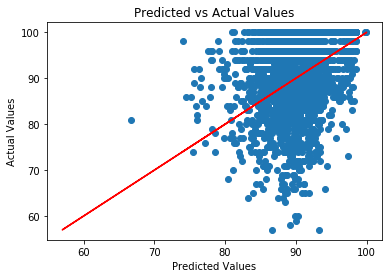

Root mean squared error of the prediction is: 7.8581223974006384
Mean absolute percentage error of the prediction is: 7.107158803745311%


In [74]:
from statsmodels.tools.eval_measures import rmse

y_preds = rfr.predict(X_test)

plt.scatter(y_preds, y_test)
plt.plot(y_test, y_test, color='red')
plt.title('Predicted vs Actual Values')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()

print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}%".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

### Bagging Regressor

In [75]:
bgr = BaggingRegressor(max_features=0.6, max_samples=1.0, n_estimators=90)
bgr.fit(X_train, y_train)

BaggingRegressor(base_estimator=None, bootstrap=True, bootstrap_features=False,
                 max_features=0.6, max_samples=1.0, n_estimators=90,
                 n_jobs=None, oob_score=False, random_state=None, verbose=0,
                 warm_start=False)

In [76]:
print('The r^2 of our test data is {}'.format(round(bgr.score(X_test, y_test), 4)))
print('The r^2 of our training data is {}'.format(round(bgr.score(X_train, y_train), 4)))

The r^2 of our test data is 0.031
The r^2 of our training data is 0.6491


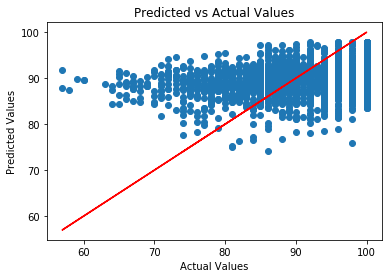

Root mean squared error of the prediction is: 7.671536847315814
Mean absolute percentage error of the prediction is: 6.99589583986725%


In [78]:
y_preds = bgr.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color='red')
plt.title('Predicted vs Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}%".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))